# Práctica 2
## Puntos de articulación y árboles abarcadores mínimos

In [26]:
sparses = [0.1,0.3,0.5,0.7,0.9]
times = {}
n_graphs = 10
n_nodes_ini = 100
n_nodes_fin = 100
step = 1
for sparse_f in sparses:
    l_t_d = time_dijkstra_d(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)
    times[sparse_f] = l_t_d[0]

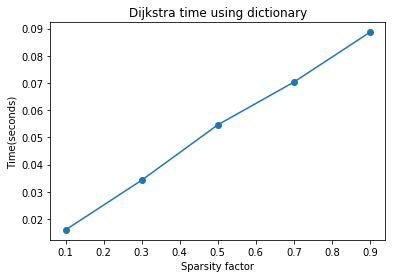

In [27]:
plt.plot(times.keys(),times.values(),'o-')
plt.xlabel("Sparsity factor")
plt.ylabel("Time(seconds)")
plt.title("Dijkstra time using dictionary")
plt.show()

In [28]:
sparses = [0.1,0.3,0.5,0.7,0.9]
times = {}
n_graphs = 10
n_nodes_ini = 100
n_nodes_fin = 100
step = 1
for sparse_f in sparses:
    l_t_d = time_dijkstra_nx(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)
    times[sparse_f] = l_t_d[0]
print(times)

{0.1: 0.04493420362472534, 0.3: 0.04616105079650879, 0.5: 0.04924250602722168, 0.7: 0.04761326313018799, 0.9: 0.047086493968963625}


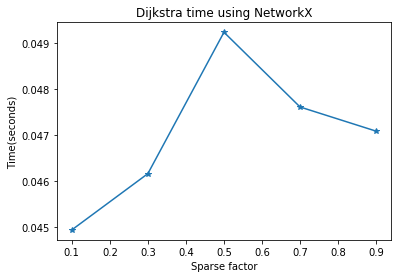

In [29]:
plt.plot(times.keys(),times.values(),'*-')
plt.xlabel("Sparse factor")
plt.ylabel("Time(seconds)")
plt.title("Dijkstra time using NetworkX")
plt.show()

In [30]:
sparses = [0.1,0.3,0.5,0.7,0.9]
times = {}
n_graphs = 100
n_nodes = 25
for sparse_f in sparses:
    l_t_d = time_dijkstra_nx(n_graphs=n_graphs, n_nodes_ini=n_nodes, 
                          n_nodes_fin=n_nodes, step=1, sparse_factor=sparse_f)
    times[sparse_f] = l_t_d[0]


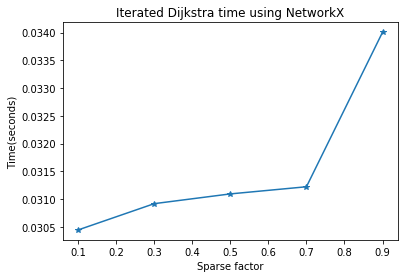

In [31]:
plt.plot(times.keys(),times.values(),'*-')
plt.xlabel("Sparse factor")
plt.ylabel("Time(seconds)")
plt.title("Iterated Dijkstra time using NetworkX")
plt.show()

# Código Práctica 1

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import time
import matplotlib.pyplot as plt
import random
import numpy as np
import pickle
import gzip
import queue as qe
import time
import networkx as nx
from sklearn.linear_model import LinearRegression

In [8]:
def rand_matr_pos_graph(n_nodes, sparse_factor, max_weight=50., decimals=0):
    """
    Funcion que genera grafos de manera aleatoria.
    Devuelve la matriz de adyacencia de un grafo dirigido ponderado.
    
    :param n_nodes: numero de nodos
    :param sparse_factor: proporcion de ramas
    :param max_weight: peso maximo
    :param decimals: numero de decimales
    """
    l = np.full((n_nodes,n_nodes),np.inf)
    branch_number = int(sparse_factor*(n_nodes)*(n_nodes-1))
    for count in range(0,branch_number):
        condition = True
        while(condition):
            i = random.randint(0,n_nodes-1)
            j = random.randint(0,n_nodes-1)
            if(j!=i and l[i,j] == np.inf):
                condition = False         
        weight = random.randint(1,max_weight)
        l[i,j] = weight
    return l

In [9]:
def cuenta_ramas(m_g):
    """
    Funcion que cuenta las ramas de un grafo.
    Devuelve el numero de ramas.
    
    :param m_g: matriz de adyacencia del grafo
    """
    n_nodes = m_g.shape[0]
    branches = 0
    for i in range(0,n_nodes):
        for j in range(0,n_nodes):
            if ((m_g[i,j] != np.inf) and i != j):
                branches+=1
    return branches

In [10]:
def m_g_sparse_factor(m_g):
    """
    Funcion auxiliar de check_sparse_factor.
    Devuelve el calculo de sparse factor de cada grafo.
    
    :param m_g: matriz de adyacencia del grafo
    """
    n_nodes = m_g.shape[0]
    return cuenta_ramas(m_g)/(n_nodes*(n_nodes-1))

def check_sparse_factor(n_grafos,n_nodes,sparse_factor):
    """
    Funcion que genera las matrices de un numero de grafos aleatorios con un numero de nodos y un sparse factor.
    Devuelve la media de los sparse factor reales de las matrices de los grafos generadas.
    
    :param n_grafos: numero de grafos
    :param n_nodes: numero de nodos del grafo
    :param sparse_factor: proporcion de ramas
    """
    sparses = []
    for i in range(0,n_grafos):
        m = rand_matr_pos_graph(n_nodes,sparse_factor)
        sparses.append(m_g_sparse_factor(m))
    return np.mean(sparses)    

In [11]:
def m_g_2_d_g(m_g):
    """
    Funcion que convierte la matriz de adyacencia del grafo en un diccionario.
    Devuelve un diccionario con cada nodo (k) asignado a otro diccionario (v) con los nodos destino (k)
    y el peso relacionado (v).
    
    :param m_g: matriz de adyacencia del grafo
    """
    n_nodes = m_g.shape[0]
    d_g = {}
    for i in range(0,n_nodes):
        d_g[i] = {}
        for j in range(0,n_nodes):
            if(m_g[i,j] != np.inf):
                d_g[i][j] = m_g[i,j]
    return d_g

In [12]:
def d_g_2_m_g(d_g):
    """
    Funcion que convierte el diccionario del grafo a una matriz de adyacencia.
    Devuelve la matriz de adyacencia resultante.
    
    :param d_g: diccionario del grafo
    """
    n_nodes = len(d_g.keys())
    m_g = np.full((n_nodes,n_nodes),np.inf)
    for node in d_g:
        for branch in d_g[node]:
            m_g[node,branch] = d_g[node][branch]
    return m_g

In [13]:
def save_object(obj, f_name="obj.pklz", save_path="."):
    """
    Funcion que guarda un objeto en un dump file.
    Realiza el volcado en cuestion, en este caso, de un grafo.
    
    :param obj: objeto a guardar
    :param f_name: nombre del objeto
    :param save_path: ruta del archivo
    """
    f = gzip.open(save_path+"/"+f_name,"wb")
    pickle.dump(obj,f)
    f.close()

def read_object(f_name, save_path="."):
    """
    Funcion que lee un objeto.
    Devuelve el objeto en cuestion.
    
    :param f_name: nombre del archivo
    :param save_path: ruta del fichero
    """
    f = gzip.open(save_path+"/"+f_name,"rb")
    obj = pickle.load(f)
    f.close()
    return obj

In [14]:
def d_g_2_TGF(d_g,f_name):
    """
    Funcion que pasa un grafo en forma de diccionario a formato TGF.
    
    :param d_g: diccionario
    :param f_name: nombre del fichero donde guardamos el grafo
    """
    f = open(f_name,"w")
    for node in d_g.keys():
        f.write("%d\n" % node)
    f.write("#\n")
    for node in d_g.keys():
        for branch in d_g[node]:
            f.write("{0} {1} {2}\n".format(node, branch, d_g[node][branch]))
    f.close()

In [15]:
def TGF_2_d_g(f_name):
    """
    Funcion que pasa un grafo en formato TGF a un diccionario.
    
    :param f_name: nombre del fichero donde se guardo el grafo
    """
    f = open(f_name,"r")
    line = f.read().split('\n')
    d_g = {}
    aux = []
    for c in line:
        aux.append(c)
        if(c == "#"):
            break
        n = int(c)
        d_g.update({n:{}})
        
    line = line[len(aux):-1]
    for c in line:
        splitted = c.split(" ")
        p1 = int(splitted[1])
        p2 = float(splitted[2])
        d_g[int(splitted[0])].update({p1:p2})
    f.close()
    return d_g

In [16]:
def dijkstra_d(d_g, u):
    """
    Funcion que aplica el algoritmo de Dijkstra a un grafo en formato de diccionario a partir de un nodo inicial.
    Devuelve un diccionario con las distancias mínimas al resto de nodos y otro que contiene el padre correspondiente
    a cada vértice accesible.
    
    :param d_g: diccionario
    :param u: nodo inicial
    """
    d_dist = {}
    d_prev = {}
    
    dist = np.full(len(d_g.keys()), np.inf)
    visitados = np.full(len(d_g.keys()), False)
    n_padre = np.full(len(d_g.keys()), None)
    
    cola = qe.PriorityQueue()
    dist[u] = 0.0
    cola.put((0.0, u))
    
    while not cola.empty():
        pos = cola.get()
        visitados[pos[1]] = True
        
        for key,value in d_g[pos[1]].items():
            if dist[key] > dist[pos[1]] + value:
                dist[key] = dist[pos[1]] + value
                n_padre[key] = pos[1]
                cola.put((dist[key], key))
   
    for n in range(len(dist)):
        d_dist.update({n:dist[n]})
        d_prev.update({n:n_padre[n]})
        
    return d_dist, d_prev

def dijkstra_m(m_g,u):
    """
    Funcion que aplica el algoritmo de Dijkstra a un grafo en formato de matriz de adyacencia a partir de un nodo inicial.
    Devuelve un diccionario con las distancias mínimas al resto de nodos y otro que contiene el padre correspondiente
    a cada vértice accesible.
    
    :param m_g: matriz de adyacencia
    :param u: nodo inicial
    """
    d_dist = {}
    d_prev = {}
    
    n_nodos = m_g.shape[0]
    dist = np.full(n_nodos, np.inf)
    visitados = np.full(n_nodos, False)
    n_padre = np.full(n_nodos, None)
    
    cola = qe.PriorityQueue()
    dist[u] = 0.0
    cola.put((0.0, u))
    
    while not cola.empty():
        pos = cola.get()
        nodo = pos[1]
        visitados[nodo] = True
        
        for adyacente in range(0,n_nodos):
            if(m_g[nodo,adyacente] != np.inf):
                if dist[adyacente] > dist[nodo] + m_g[nodo,adyacente]:
                    dist[adyacente] = dist[nodo] + m_g[nodo,adyacente]
                    n_padre[adyacente] = nodo
                    cola.put((dist[adyacente], adyacente))
            
    for n in range(len(dist)):
        d_dist.update({n:dist[n]})
        d_prev.update({n:n_padre[n]})
        
    return d_dist, d_prev

In [17]:
def min_paths(d_prev):
    """
    Funcion que devuelve el diccionario con el camino minimo desde el nodo inicial a otro nodo
    
    :param d_prev: diccionario que contiene el padre correspondiente a cada vértice accesible.
    """
    inicial = -1
    for key in d_prev:
        if(d_prev[key] == None):
            inicial = key
    if(inicial == -1):
        raise Exception("La lista de padres no contiene un nodo inicial con padre = None")
    d_paths = {}
    for nodo in d_prev:
        path = []
        condicion = True
        
        nodo_padre = nodo
        while(condicion):
            if(nodo_padre == None):
                path.reverse()
                d_paths[nodo] = path
                condicion = False
            else:
                path.append(nodo_padre)
                nodo_padre = d_prev[nodo_padre]
    return d_paths

In [18]:
def time_dijkstra_m(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    """
    Funcion que calcula el tiempo de aplicar Dijkstra a un grafo dado en formato de matriz de adyacencia.
    Devuelve una lista de tiempos para cada grafo al que se le ha aplicado el algoritmo.
    
    :param n_graphs: numero de grafos a generar
    :param n_nodes_ini: num de nodos inicial
    :param n_nodes_fin: num de nodos final
    :param step: incremento
    :param sparse_factor: factor proporcion de ramas
    """
    diccionario_grafos = {}
    lista_tiempos = []
    for i in range(0,n_graphs):
        for n_nodos in range(n_nodes_ini,n_nodes_fin+1,step):
            if(n_nodos not in diccionario_grafos.keys()):
                diccionario_grafos[n_nodos] = []
            m_g = rand_matr_pos_graph(n_nodos, sparse_factor)
            diccionario_grafos[n_nodos].append(m_g)
   
    for n_nodos in diccionario_grafos.keys():
        
        tiempo_ini = time.time()
        for i in range(0,n_graphs):
            for nodo in range(0,n_nodos):
                dijkstra_m(diccionario_grafos[n_nodos][i],nodo)
        tiempo_fin = time.time()-tiempo_ini
        lista_tiempos.append(tiempo_fin/n_nodos)

    return lista_tiempos    

In [19]:
def time_dijkstra_d(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    """
    Funcion que calcula el tiempo de aplicar Dijkstra a un grafo dado en formato diccionario.
    Devuelve una lista de tiempos para cada grafo al que se le ha aplicado el algoritmo.
    
    :param n_graphs: numero de grafos a generar
    :param n_nodes_ini: num de nodos inicial
    :param n_nodes_fin: num de nodos final
    :param step: incremento
    :param sparse_factor: factor proporcion de ramas
    """
    diccionario_grafos = {}
    lista_tiempos = []
    for i in range(0,n_graphs):
        for n_nodos in range(n_nodes_ini,n_nodes_fin+1,step):
            if(n_nodos not in diccionario_grafos.keys()):
                diccionario_grafos[n_nodos] = []
            d_g = m_g_2_d_g(rand_matr_pos_graph(n_nodos, sparse_factor))
            diccionario_grafos[n_nodos].append(d_g)
           
    for n_nodos in diccionario_grafos.keys():
        
        tiempo_ini = time.time()
        for i in range(0,n_graphs):
            for nodo in range(0,n_nodos):
                dijkstra_d(diccionario_grafos[n_nodos][i],nodo)
        tiempo_fin = time.time()-tiempo_ini
        lista_tiempos.append(tiempo_fin/n_nodos)

    return lista_tiempos

In [20]:
def d_g_2_nx_g(d_g):
    """
    Funcion que pasa un grafo en formato de diccionario a otro de Networkx.
    
    :param d_g: diccionario
    """
    l_e = []
    g = nx.DiGraph()
    
    for key,value in d_g.items():
        for key2,value2 in value.items():
            l_e.append((key,key2,value2))
            
    g.add_weighted_edges_from(l_e)
    return g

In [21]:
def nx_g_2_d_g(nx_g):
    """
    Funcion que pasa un grafo en formato Networkx a otro en formato diccionario.
    
    :param nx_g: grafo en formato Networkx
    """
    d_g = {}
    
    for count in nx_g.nodes():
        for key,value in nx_g[count].items():
            if d_g.get(count) == None:
                d_g.update({count:{}})
            for key2,value2 in value.items():
                d_g[count][key]=value2
    
    return d_g

In [22]:
def time_dijkstra_nx(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    """
    Funcion que calcula el tiempo de aplicar Dijkstra a un grafo dado en formato de Networkx.
    Devuelve una lista de tiempos para cada grafo al que se le ha aplicado el algoritmo.
    
    :param n_graphs: numero de grafos a generar
    :param n_nodes_ini: num de nodos inicial
    :param n_nodes_fin: num de nodos final
    :param step: incremento
    :param sparse_factor: factor proporcion de ramas
    """
    diccionario_grafos = {}
    lista_tiempos = []
    for i in range(0,n_graphs):
        for n_nodos in range(n_nodes_ini,n_nodes_fin+1,step):
            if(n_nodos not in diccionario_grafos.keys()):
                diccionario_grafos[n_nodos] = []
            m_g = rand_matr_pos_graph(n_nodos, sparse_factor)
            g = nx.from_numpy_matrix(m_g)
            diccionario_grafos[n_nodos].append(g)
            
    for n_nodos in diccionario_grafos.keys():
        
        tiempo_ini = time.time()
        for i in range(0,n_graphs):
            for nodo in range(0,n_nodos):
                nx.single_source_dijkstra(diccionario_grafos[n_nodos][i],nodo)
        tiempo_fin = time.time()-tiempo_ini
        lista_tiempos.append(tiempo_fin/n_nodos)

    return lista_tiempos

In [23]:
def fit_plot(l, func_2_fit, size_ini, size_fin, step,legend=None):
    """
    Funcion que entrena un modelo lineal con unas listas de tiempos y devuelve el real y la prediccion de cada uno.
    
    :param l: lista
    :param func_2_fit: funcion en concreto a entrenar, sera en nuestro caso n**2log(n)
    :param size_ini: tamaño inicial
    :param size_fin: tamaño final
    :param step: incremento
    :param legend: parametro que hemos añadido para diferenciar las leyendas segun el formato en el que se pase el grafo
    """
    l_func_values =[i*func_2_fit(i) for i in range(size_ini, size_fin+1, step)]
    
    lr_m = LinearRegression()
    X = np.array(l_func_values).reshape( len(l_func_values), -1 )
    lr_m.fit(X, l)
    y_pred = lr_m.predict(X)
    
    
    trueLegend="True " + legend
    predictedLegend = "Pred. " + legend
    
    plt.plot(l, '*',label=trueLegend)
    plt.plot(y_pred, '-',label=predictedLegend)
    plt.legend()
    plt.title("Time comparative")
    plt.xlabel("Number of nodes")
    plt.ylabel("Time*number of nodes (seconds)")

def n2_log_n(n):
    return n**2. * np.log(n)

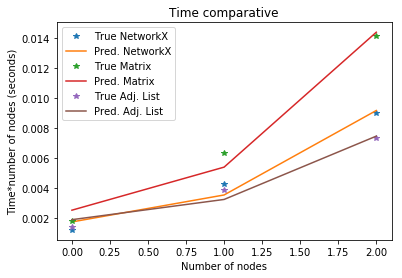

In [24]:
n_graphs=20
n_nodes_ini=10 
n_nodes_fin=30
step=10
sparse_f= 0.25
l_t_nx = time_dijkstra_nx(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)
l_t_m = time_dijkstra_m(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)
l_t_d = time_dijkstra_d(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)

fit_plot(l_t_nx, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step,legend="NetworkX")
fit_plot(l_t_m, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step,legend="Matrix")
fit_plot(l_t_d, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step,legend="Adj. List")

# Pruebas

In [25]:
import string, random
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

import queue as qe

from sklearn.linear_model import LinearRegression

import networkx as nx

In [ ]:
l = [
[0, 10, 1, np.inf],
[np.inf, 0, 1, np.inf],
[np.inf, np.inf, 0, 1 ],
[np.inf, 1, np.inf, 0]
]

m_g = np.array(l)

def print_m_g(m_g):
    print("graph_from_matrix:\n")
    n_v = m_g.shape[0]
    for u in range(n_v):
        for v in range(n_v):
            if v != u and m_g[u, v] != np.inf:
                print("(", u, v, ")", m_g[u, v])

            
d_g = {
0: {1: 10, 2: 1}, 
1: {2: 1}, 
2: {3: 1},
3: {1: 1}
}

def print_d_g(d_g):
    print("\ngraph_from_dict:\n")
    for u in d_g.keys():
        for v in d_g[u].keys():
            print("(", u, v, ")", d_g[u][v])
            
print_m_g(m_g)
print_d_g(d_g)

In [ ]:
m_g = rand_matr_pos_graph(n_nodes=5, sparse_factor=0.5, max_weight=50.)    
d_g = m_g_2_d_g(m_g)
m_g_2 = d_g_2_m_g(d_g)

print_m_g(m_g)
print_d_g(d_g)
print("\nnum_elem_iguales:\t%d" % (m_g_2 == m_g).sum() )

In [ ]:
print(cuenta_ramas(m_g))

n_grafos=50
n_nodes=20
sparse_factor = 0.75

print("\ntrue_sparse_factor: %.3f" % sparse_factor, 
      "\nexp_sparse_factor:  %.3f" % check_sparse_factor(n_grafos=n_grafos, n_nodes=n_nodes, sparse_factor=sparse_factor))

In [ ]:
f_name = "gr.tgf"
d_g_2_TGF(d_g, f_name)
                       
d_g_2 = TGF_2_d_g(f_name)            
print_d_g(d_g)
print_d_g(d_g_2)

In [ ]:
d_g = {
0: {1: 10, 2: 1}, 
1: {2: 1}, 
2: {3: 1},
3: {1: 1}
}

u_ini = 3

d_dist, d_prev = dijkstra_d(d_g, u_ini)
print(d_dist, '\n', min_paths(d_prev))

d_g_nx = nx.DiGraph()
l_e = [(0, 1, 10), (0, 2, 1), (1, 2, 1), (2, 3, 1), (3, 1, 1)]
d_g_nx.add_weighted_edges_from(l_e)

d, p = nx.single_source_dijkstra(d_g_nx, u_ini, weight='weight')    
print(d, '\n', p)

In [ ]:
n_graphs=100
n_nodes_ini=10 
n_nodes_fin=100
step=10
sparse_f= 0.25
l_t_d = time_dijkstra_d(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                        n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)

In [ ]:
fit_plot(l_t_d, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)

In [ ]:
g = nx.DiGraph()

l_e = [(0, 1, 10), (0, 2, 1), (1, 2, 1), (2, 3, 1), (3, 1, 1)]
g.add_weighted_edges_from(l_e)

for k1 in g.nodes():
    for k2 in g[k1].keys():
        print('(', k1, k2, ')', g[k1][k2]['weight'])

In [ ]:
d_g = {
0: {1: 10, 2: 1}, 
1: {2: 1}, 
2: {3: 1},
3: {1: 1}
}

d_g_nx = d_g_2_nx_g(d_g)

print_d_g(d_g)
(d_g_nx)[0][1]

In [ ]:
n_graphs=100
n_nodes_ini=10 
n_nodes_fin=100
step=10
sparse_f= 0.25
l_t_nx = time_dijkstra_nx(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)

In [ ]:
fit_plot(l_t_nx, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)

In [ ]:
l_t_d = time_dijkstra_d(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)

In [ ]:
sparses = [0.1,0.3,0.5,0.7,0.9]
times = {}
n_graphs = 100
n_nodes_ini = 50
n_nodes_fin = 50
step = 1
for sparse_f in sparses:
    l_t_d = time_dijkstra_d(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)
    times[sparse_f] = l_t_d[0]



In [ ]:
plt.plot(times.keys(),times.values(),'*')
plt.show()

In [ ]:
sparses = [0.1,0.3,0.5,0.7,0.9]
times = {}
n_graphs = 10
n_nodes_ini = 100
n_nodes_fin = 100
step = 1
for sparse_f in sparses:
    l_t_d = time_dijkstra_nx(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)
    times[sparse_f] = l_t_d[0]

In [ ]:
plt.plot(times.keys(),times.values(),'*')
plt.show()

# Código Práctica 2

In [2]:
import random
import numpy as np

In [3]:
def graph_2_multigraph(d_g):
    d_mg = {}
    for nodo in d_g.keys():
        d_mg.update({nodo:{}})
        for k,v in d_g[nodo].items():
            d_mg[nodo].update({k:{0:v}})
    return d_mg

In [4]:
mG = nx.MultiDiGraph()
l_e = [(0, 1, 10), (0, 2, 1), (1, 2, 1), (2, 3, 1), (3, 1, 1)]
mG.add_weighted_edges_from(l_e)
mG.add_weighted_edges_from(l_e)
print(mG[0])

NameError: name 'nx' is not defined

In [5]:
print(mG[1])

NameError: name 'mG' is not defined

In [6]:
d_g = {
0: {1: 10, 2: 1}, 
1: {2: 1}, 
2: {3: 1},
3: {1: 1}
}
m = graph_2_multigraph(d_g)
print(m)

{0: {1: {0: 10}, 2: {0: 1}}, 1: {2: {0: 1}}, 2: {3: {0: 1}}, 3: {1: {0: 1}}}


In [7]:
def rand_weighted_multigraph(n_nodes, prob=0.2, num_max_multiple_edges=1, max_weight=50., decimals=0, fl_unweighted=False,
fl_diag=True):
    d_mg = {}
    
    
    for nodo in range(0,n_nodes):
        d_mg[nodo] = {}
        for rama in range(0,n_nodes):
            d_mg[nodo][rama] = {}
            if( not (fl_diag == False and rama == nodo)):
                ramas = np.random.rand()
                if(ramas<prob): # si es menor, hay ramas
                    n_ramas = np.random.randint(1,num_max_multiple_edges+1)
                    for indice in range(0,n_ramas):
                        if(fl_unweighted == False):
                            peso = round(np.random.rand()*max_weight,decimals)
                        else:
                            peso = 1
                        d_mg[nodo][rama][indice] = peso
    return d_mg
        

In [8]:
def rand_weighted_undirected_multigraph(n_nodes, prob=0.2, num_max_multiple_edges=1, max_weight=50., decimals=0, fl_unweighted
=False, fl_diag=True):
    d_mg = {}
    
    # creamos el grafo dirigido
    for nodo in range(0,n_nodes):
        d_mg[nodo] = {}
        for rama in range(0,n_nodes):
            d_mg[nodo][rama] = {}
            if( not (fl_diag == False and rama == nodo)):
                ramas = np.random.rand()
                if(ramas<prob): # si es menor, hay ramas
                    n_ramas = np.random.randint(1,num_max_multiple_edges+1)
                    for indice in range(0,n_ramas):
                        if(fl_unweighted == False):
                            peso = round(np.random.rand()*max_weight,decimals)
                        else:
                            peso = 1
                        d_mg[nodo][rama][indice] = peso
    d_mg
g = rand_weighted_multigraph(5,prob=0.8,fl_diag=False)
for nodo in g:
    print(nodo,g[nodo])

0 {0: {}, 1: {0: 22.0}, 2: {0: 5.0}, 3: {0: 25.0}, 4: {0: 17.0}}
1 {0: {0: 44.0}, 1: {}, 2: {0: 5.0}, 3: {}, 4: {0: 50.0}}
2 {0: {0: 24.0}, 1: {0: 39.0}, 2: {}, 3: {}, 4: {0: 5.0}}
3 {0: {0: 35.0}, 1: {0: 18.0}, 2: {}, 3: {}, 4: {0: 17.0}}
4 {0: {0: 18.0}, 1: {0: 21.0}, 2: {0: 23.0}, 3: {0: 50.0}, 4: {}}


In [9]:
def rand_weighted_undirected_multigraph(n_nodes, prob=0.2, num_max_multiple_edges=1, max_weight=50., decimals=0, fl_unweighted
=False, fl_diag=True):
    d_mg = {}
    
    # creamos el grafo dirigido
    for nodo in range(0,n_nodes):
        d_mg[nodo] = {}
        #podriamos decidir si hay autorramas
        for rama in range(0,nodo):
            d_mg[nodo][rama] = {}
            d_mg[rama][nodo]= {}
            if( not (fl_diag == False and rama == nodo)):
                ramas = np.random.rand()
                if(ramas<prob): # si es menor, hay ramas
                    n_ramas = np.random.randint(1,num_max_multiple_edges+1)
                    for indice in range(0,n_ramas):
                        if(fl_unweighted == False):
                            peso = round(np.random.rand()*max_weight,decimals)
                        else:
                            peso = 1
                        d_mg[nodo][rama][indice] = peso
                        
                    d_mg[rama][nodo][indice] = peso
                        
    return d_mg


g = rand_weighted_undirected_multigraph(5,prob=0.8,fl_diag=False)
for nodo in g:
    print(nodo,g[nodo])

0 {1: {0: 25.0}, 2: {0: 5.0}, 3: {0: 6.0}, 4: {0: 35.0}}
1 {0: {0: 25.0}, 2: {0: 31.0}, 3: {0: 29.0}, 4: {}}
2 {0: {0: 5.0}, 1: {0: 31.0}, 3: {0: 17.0}, 4: {0: 37.0}}
3 {0: {0: 6.0}, 1: {0: 29.0}, 2: {0: 17.0}, 4: {}}
4 {0: {0: 35.0}, 1: {}, 2: {0: 37.0}, 3: {}}


In [ ]:
def o_a_tables(u, d_g, p, s, o, a, c):
    pass